In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import fbeta_score, cohen_kappa_score

from imblearn.over_sampling import SMOTE 
from imblearn import under_sampling, over_sampling
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from collections import defaultdict
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn import svm

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split


import time
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter 

%matplotlib inline

import shap

Using TensorFlow backend.
/Users/luyuankong/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/luyuankong/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/luyuankong/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/l

# Load the data

In [2]:
#pickle the df we cleaned up earlier
with open("clean_df.pickle", "rb") as f:
    clean_df = pickle.load(f)

In [3]:
# reorder the columns by numerical and categorical

clean_df = clean_df[['gender', 'graduate school', 'high school', 'university',
       'married', 'single' ,'count_pay_duly', 'age','limit_bal','bill_amt1',
       'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6',
       'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6','default']]

In [4]:
clean_df.columns

Index(['gender', 'graduate school', 'high school', 'university', 'married',
       'single', 'count_pay_duly', 'age', 'limit_bal', 'bill_amt1',
       'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6',
       'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default'],
      dtype='object')

In [5]:
clean_df.to_csv(r'p3.csv', index=False) 

# Preprocessing the data

In [26]:
X = clean_df.iloc[:,:-1]
y = clean_df.iloc[:,-1:]


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [28]:
# StandardScaler that implements the Transformer API to compute the mean and standard deviation on a training set 
#so as to be able to later reapply the same transformation on the testing set
scaler = StandardScaler()

In [29]:
X_train_cat = X_train.iloc[:,:7]

In [30]:
X_train_num = X_train.iloc[:, 7:]

In [31]:
X_train_num_scaled = scaler.fit_transform(X_train_num)

In [32]:
X_train_scaled = np.column_stack((np.array(X_train_cat), X_train_num_scaled))

In [33]:
# always check the shape of X_train_scaled and X_test_scaled
X_train_scaled.shape

(24000, 21)

In [34]:
# remember you have to modify the same columns on yout test set
X_test_scaled_part = scaler.transform(X_test.iloc[:,7:].values)

In [35]:
X_test_scaled = np.column_stack((X_test.iloc[:, :7].values, X_test_scaled_part))

In [36]:
X_test_scaled.shape

(6000, 21)

# Hyperparameter tuning 

In [18]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import fbeta_score, make_scorer
import pprint as pp

In [20]:
ftwo_scorer = make_scorer(fbeta_score, beta=2) 

## Knn

In [ ]:
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
ftwo_scorer = make_scorer(fbeta_score, beta=2)
param_dist = dict(n_neighbors=k_range, weights=weight_options)
rand = RandomizedSearchCV(KNeighborsClassifier(), param_dist, cv=5, scoring=ftwo_scorer, n_iter=10, random_state=42)
rand.fit(X_train_scaled, y_train)

In [ ]:
print('Best Score: ', rand.best_score_)
print('Best Params: ', rand.best_params_)

## Logistic

In [ ]:
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
solver = ['liblinear', 'saga']
param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)
grid = GridSearchCV(estimator=LogisticRegression(),
                    param_grid=param_grid,
                    scoring=ftwo_scorer,
                    verbose=1)
grid_result = grid.fit(X_train_scaled, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

## XGBoost

In [ ]:
paramgrid_xgb = {
    'classifier__n_estimators': [10, 100, 250, 500, 1000],
    'classifier__max_depth': [3, 4, 5]
}

# Define fold parameters
kf_xgb = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb = XGBClassifier()

model = Pipeline([('sampling', SMOTE()), 
                  ('classifier', xgb)])

grid_xgb = GridSearchCV(model, param_grid = paramgrid_xgb, n_jobs = 1, cv = kf_xgb, verbose = True)
grid_xgb.fit(X_train_scaled, y_train)

In [ ]:
rank_params = list(zip(grid_xgb.cv_results_['rank_test_score'], grid_xgb.cv_results_['params'], grid_xgb.cv_results_['mean_test_score']))
pp.pprint(sorted(rank_params, key = lambda x:x[0]))

In [ ]:
grid_xgb.cv_results_['mean_test_score']

In [ ]:
grid_xgb.best_params_

## Random Forest

In [22]:
pipe = Pipeline([('clf', RandomForestClassifier())])
param_grid_rf = [{'clf__max_depth': [3, 4], 'clf__max_features': [5, 10, 15, 20], 'clf__n_estimators': [50, 100, 150]}]
gs = GridSearchCV(pipe, param_grid_rf, cv=5, n_jobs=-1, scoring=ftwo_scorer)
gs.fit(X_train_scaled, y_train)

/Users/luyuankong/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:291: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                              

In [23]:
gs.best_params_

{'clf__max_depth': 4, 'clf__max_features': 20, 'clf__n_estimators': 100}

# Model Selection
## Cross Validation

Precision is a good measure to determine, when the costs of False Positive is high. Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.

TP: defalut identified as default. we correctly identify the unreliable customes. 坏人抓到啦 
FP: not default identified as default. Customers who are reliable are identified as default. 冤枉好人 
TN: not default identified as not default. 好人被认出 
FN: default identified as not default.The cutomers who are reliable are correcly identified. 坏人被认成好人

Identifying accurately which customers are most probable to default represents significant business opportunity for all banks.

Our clients: banks

Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.Our obejective is to help the bank identify and take action on customers with high probability of defaulting to improve their bottom line.

In [37]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

#collect results for each model
cv_results_recall = defaultdict(list) 
cv_results_precision = defaultdict(list) 
cv_results_f1 = defaultdict(list) 
cv_results_accuracy = defaultdict(list) 
cv_results_fbeta =  defaultdict(list)

# generate indies for kf
y_train = y_train.values

# choose n_neighbors as
models = {'Xgboost':XGBClassifier(classifier__max_depth = 4, classifier__n_estimators = 500),
          'GNB': GaussianNB(),
          'Logistic Regression': LogisticRegression(C= 10, class_weight= {1: 0.7, 0: 0.3}, penalty= 'l2', solver= 'liblinear'),
          'Random Forest':RandomForestClassifier(max_depth = 4, max_features=20, n_estimators= 100),
          'Linearsvc': LinearSVC(),
          'Knn':KNeighborsClassifier(weights = 'uniform', n_neighbors=1)}
          
for model_name, model in models.items():
    for train_ind, val_ind in kf.split(X_train_scaled, y_train):
        X_tr, y_tr = X_train_scaled[train_ind], y_train[train_ind]
    
        X_smote_train, y_smote_train = SMOTE(random_state=42).fit_sample(X_tr, y_tr)

        X_val,y_val = X_train_scaled[val_ind], y_train[val_ind]

        model.fit(X_smote_train, y_smote_train)

        y_pred = model.predict(X_val)

        # calculate recall score
        recall = recall_score(y_val, y_pred) 

        cv_results_recall[model_name].append(recall)
        
        # calculate precision score
        
        precision = precision_score(y_val, y_pred) 

        cv_results_precision[model_name].append(precision)
        
        # calculate f1 score
        f1 = f1_score(y_val,y_pred)
        
        cv_results_f1[model_name].append(f1)
        
        #calculate fbeta score
        fbeta = fbeta_score(y_val, y_pred, beta=2)
        
        cv_results_fbeta[model_name].append(fbeta)
        # calculate accuracy
        
        accuracy = accuracy_score(y_val,y_pred)
        
        cv_results_accuracy[model_name].append(accuracy)

/Users/luyuankong/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/luyuankong/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/luyuankong/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/luyuankong/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expec

In [38]:
model_lst = list(cv_results_recall.keys())
recall_mean = [np.mean(i) for i in cv_results_recall.values()]
recall_var = [np.var(i) for i in cv_results_recall.values()]
df_cv_recall = pd.DataFrame(
    {'model_name': model_lst,
     'recall_mean': recall_mean,
     'recal_var': recall_var
    })

In [ ]:
#the model with the best mean score and least amount of variance in performance is chosen

In [39]:
precision_mean = [np.mean(i) for i in cv_results_precision.values()]
precision_var = [np.var(i) for i in cv_results_precision.values()]
df_cv_precision = pd.DataFrame(
    {
     'pre_mean': precision_mean,
     'pre_var': precision_var
    })

In [40]:
fbeta_mean = [np.mean(i) for i in cv_results_fbeta.values()]
fbeta_var = [np.var(i) for i in cv_results_fbeta.values()]
df_cv_fbeta = pd.DataFrame(
    {
     'fbeta_mean': fbeta_mean,
     'fbeta_var': fbeta_var
    })

In [41]:
f1_mean = [np.mean(i) for i in cv_results_f1.values()]
f1_var = [np.var(i) for i in cv_results_f1.values()]
df_cv_f1 = pd.DataFrame(
    {
     'f1_mean': f1_mean,
     'f1_var': f1_var
    })

In [42]:
df_score = pd.concat([df_cv_recall,df_cv_precision,df_cv_f1,df_cv_fbeta], join='outer', axis=1)

In [43]:
df_score

,model_name,recall_mean,recal_var,pre_mean,pre_var,f1_mean,f1_var,fbeta_mean,fbeta_var
0,Xgboost,0.516098,0.000509,0.387399,1.884228e-04,0.442384,0.000218,0.483781,0.000336
1,GNB,0.925413,0.000136,0.239530,1.224808e-05,0.380549,0.000026,0.588406,0.000052
2,Logistic Regression,0.948768,0.000039,0.241435,8.126128e-07,0.384916,0.000002,0.598229,0.000006
3,Random Forest,0.627982,0.001316,0.332112,2.250999e-04,0.433629,0.000109,0.532032,0.000306
4,Linearsvc,0.716144,0.000127,0.296065,2.056911e-05,0.418919,0.000035,0.557817,0.000061
5,Knn,0.376154,0.000056,0.283745,6.666370e-05,0.323447,0.000057,0.353125,0.000053


## Fit model into test set

In [45]:
X_sm,y_sm = SMOTE(random_state = 42).fit_sample(X_train_scaled, y_train)

/Users/luyuankong/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [47]:
def evaluate(model_name):
    """
    input: model name
    returns recall and fbeta score when beta =2
    """
    model_name.fit(X_sm, y_sm)
    rec_s = recall_score(y_test, model_name.predict(X_test_scaled))
    fb_s = fbeta_score(y_test, model_name.predict(X_test_scaled), beta=2)
    return rec_s, fb_s 
    

In [55]:
xgb = XGBClassifier(classifier__max_depth = 4, classifier__n_estimators = 500)
gnb = GaussianNB()
lr = LogisticRegression(C= 10, class_weight= {1: 0.7, 0: 0.3}, penalty= 'l2', solver= 'liblinear')
rf = RandomForestClassifier(max_depth = 4, max_features=20, n_estimators= 100)
knn = KNeighborsClassifier(weights = 'uniform', n_neighbors=1)

In [57]:
mod_lst = [xgb,
           gnb,
           lr,
           rf,
           knn
    
]

In [59]:
fbeta_scr = [evaluate(m)[-1] for m in mod_lst]

In [60]:
list(zip(mod_lst,fbeta_scr))

[(XGBClassifier(base_score=0.5, booster='gbtree', classifier__max_depth=4,
                classifier__n_estimators=500, colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0,
                learning_rate=0.1, max_delta_step=0, max_depth=3,
                min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
                nthread=None, objective='binary:logistic', random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                silent=None, subsample=1, verbosity=1), 0.47930743243243246),
 (GaussianNB(priors=None, var_smoothing=1e-09), 0.5921179417999615),
 (LogisticRegression(C=10, class_weight={0: 0.3, 1: 0.7}, dual=False,
                     fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                     max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                     warm_start=False), 0

## ROC Curve

In [61]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb.predict_proba(X_test_scaled)[:,1])
auc_xgb = roc_auc_score(y_test, xgb.predict_proba(X_test_scaled)[:, 1]) 

fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test, gnb.predict_proba(X_test_scaled)[:,1])
auc_gnb = roc_auc_score(y_test, gnb.predict_proba(X_test_scaled)[:, 1]) 

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, lr.predict_proba(X_test_scaled)[:,1])
auc_lr = roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:, 1]) 

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test_scaled)[:,1])
auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1]) 

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn.predict_proba(X_test_scaled)[:,1])
auc_knn = roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:, 1]) 

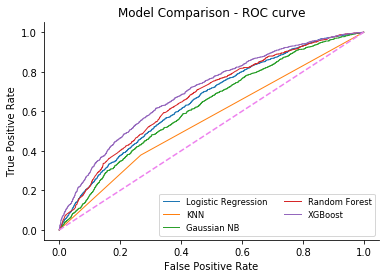

In [62]:
plt.plot(fpr_lr, tpr_lr, lw=1, label='Logistic Regression')
plt.plot(fpr_knn, tpr_knn, lw=1, label='KNN')
plt.plot(fpr_gnb, tpr_gnb, lw=1, label='Gaussian NB')
plt.plot(fpr_rf, tpr_rf, lw=1, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, lw=1, label='XGBoost')


plt.plot([0, 1], [0, 1], c='violet', ls='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Comparison - ROC curve')
plt.legend(ncol=2, fontsize='small')
sns.despine()
plt.savefig('model_comp_roc_scaled_2.png')

# Confusion Matrix

In [125]:
annots = pd.DataFrame([['TN', 'FP'], ['FN', 'TP']])
type(annots)
annots

,0,1
0,TN,FP
1,FN,TP


In [106]:
# using the new threshold of 0.96
y_predict_gnb = (gnb.predict_proba(X_test_scaled)[:,1] > 0.96)
print("Threshold of 0.96:")
print("Precision: {:6.4f}, Recall: {:6.4f}, Fbeta :{:6.4f}".format(precision_score(y_test, y_predict_gnb), 
                                                     recall_score(y_test, y_predict_gnb),
                                                     fbeta_score(y_test, y_predict_gnb, beta=2 )))

Threshold of 0.96:
Precision: 0.2776, Recall: 0.6669, Fbeta :0.5208


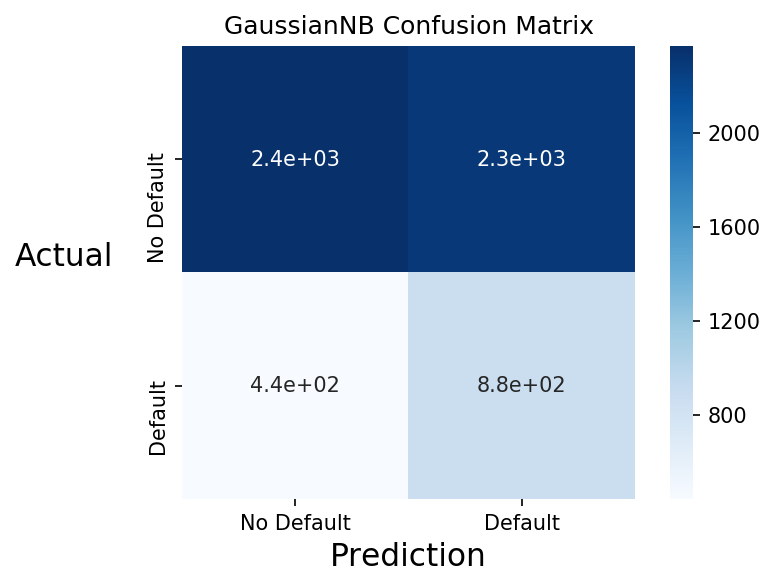

<Figure size 432x288 with 0 Axes>

In [107]:
# Print confusion matrix for Gaussian NB
gnb_confusion = confusion_matrix(y_test, y_predict_gnb)

plt.figure(dpi=150)
sns.heatmap(gnb_confusion, cmap=plt.cm.Blues, annot=True,
            square=True,
           xticklabels=['No Default', 'Default'],
           yticklabels=['No Default', 'Default']);

b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values

plt.xlabel('Prediction', size=15)
plt.ylabel('Actual', rotation=0, labelpad=40,size=15)
plt.title('GaussianNB Confusion Matrix');
plt.show()
plt.savefig('confusion_gnb_scaled_2.png')

In [126]:
# using the new threshold of 0.5
y_predict_lr = (lr.predict_proba(X_test_scaled)[:,1] > 0.73)
print("Threshold of 0.7:")
print("Precision: {:6.4f}, Recall: {:6.4f}, Fbeta :{:6.4f}".format(precision_score(y_test, y_predict_lr), 
                                                     recall_score(y_test, y_predict_lr),
                                                     fbeta_score(y_test, y_predict_lr, beta=2 )))

Threshold of 0.7:
Precision: 0.3065, Recall: 0.5855, Fbeta :0.4953


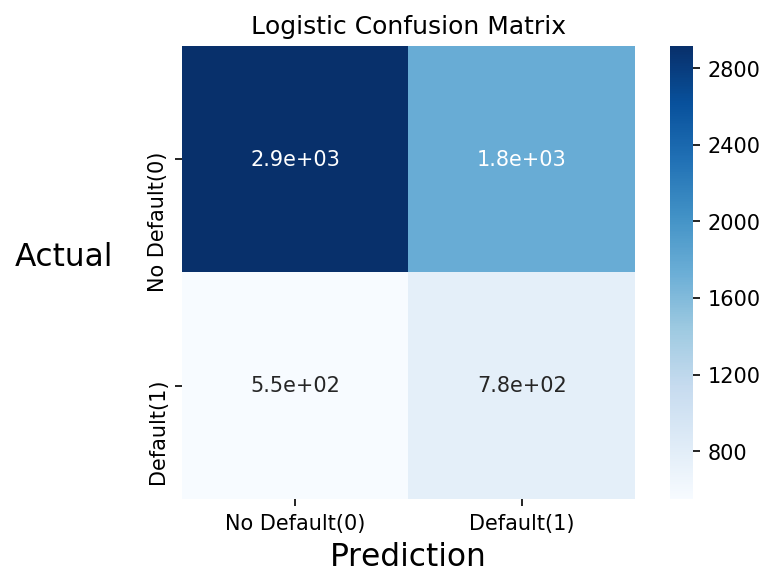

<Figure size 432x288 with 0 Axes>

In [127]:
# Print confusion matrix for Gaussian NB
lr_confusion = confusion_matrix(y_test, y_predict_lr)

plt.figure(dpi=150)
sns.heatmap(lr_confusion, cmap=plt.cm.Blues, annot=True,
            square=True,
           xticklabels=['No Default(0)', 'Default(1)'],
           yticklabels=['No Default(0)', 'Default(1)']);

b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values

plt.xlabel('Prediction', size=15)
plt.ylabel('Actual', rotation=0, labelpad=40,size=15)
plt.title('Logistic Confusion Matrix');
plt.show()
plt.savefig('confusion_logistic_scaled.png')

# Feature Importance

In [131]:
lr.coef_

array([[-0.18551486,  1.59074196,  1.5351035 ,  1.58402208,  0.45608548,
         0.25031792, -0.03584555,  0.0385044 , -0.39442327, -0.60388161,
         0.42546033, -0.02712567,  0.10218215,  0.35401891, -0.02354116,
        -0.39317892, -0.33769648, -0.09779742, -0.15028123, -0.03755609,
        -0.0470378 ]])

In [134]:
X.columns

Index(['gender', 'graduate school', 'high school', 'university', 'married',
       'single', 'count_pay_duly', 'age', 'limit_bal', 'bill_amt1',
       'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6',
       'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6'],
      dtype='object')

In [135]:
clean_df.default

0        1
1        1
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       1
14       0
15       0
16       1
17       0
18       0
19       0
20       0
21       1
22       1
23       1
24       0
25       0
26       1
27       0
28       0
29       0
        ..
29970    0
29971    0
29972    0
29973    1
29974    1
29975    0
29976    1
29977    0
29978    0
29979    0
29980    0
29981    0
29982    1
29983    0
29984    0
29985    0
29986    0
29987    0
29988    0
29989    0
29990    0
29991    1
29992    0
29993    0
29994    1
29995    0
29996    0
29997    1
29998    1
29999    1
Name: default, Length: 30000, dtype: int64

In [98]:
lr_coefs = pd.DataFrame(sorted(list(zip(X.columns, lr.coef_[0])),
                                   key=(lambda x: x[1]),
                                   reverse=True),
                            columns=['Feature', 'Coefficient'])

In [99]:
lr_coefs #corresponds to outcome 1 which is default

,Feature,Coefficient
0,graduate school,1.590742
1,university,1.584022
2,high school,1.535104
3,married,0.456085
4,bill_amt2,0.425460
5,bill_amt5,0.354019
6,single,0.250318
7,bill_amt4,0.102182
8,age,0.038504
9,bill_amt6,-0.023541


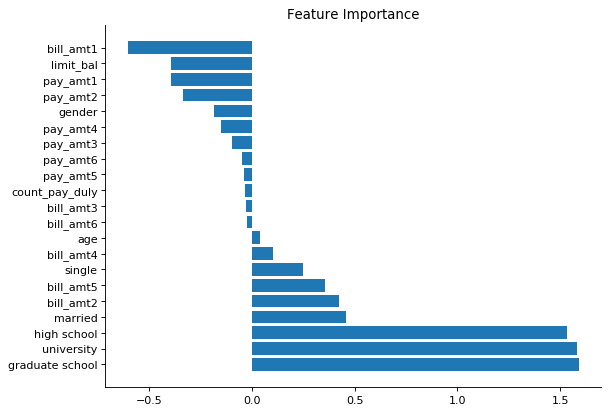

In [132]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

lr_coefs['Odds'] = np.exp(lr_coefs.Coefficient)
plt.barh(lr_coefs['Feature'], width=lr_coefs['Coefficient'])
plt.title('Feature Importance')
plt.grid(b=False)
sns.despine()

In [124]:
with open("lr_coefs.pkl", "wb") as f:
    pickle.dump(lr_coefs, f)

In [129]:
lr_coefs

,Feature,Coefficient,Odds
0,graduate school,1.590742,4.907389
1,university,1.584022,4.874522
2,high school,1.535104,4.641806
3,married,0.456085,1.577885
4,bill_amt2,0.425460,1.530295
5,bill_amt5,0.354019,1.424782
6,single,0.250318,1.284434
7,bill_amt4,0.102182,1.107585
8,age,0.038504,1.039255
9,bill_amt6,-0.023541,0.976734


In [128]:

# convert intercept log-odds to probability
logodds = lr.intercept_
odds = np.exp(logodds)
prob = odds / (1 + odds)
prob[0]


0.2580269283694775